# Regressão Logística I
## Tarefa II

Vamos trabalhar com a mesma base do exercício anterior, mas vamos aprofundar um pouco mais a nossa regressão.

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from scipy.stats import ks_2samp
import statsmodels.formula.api as smf

In [6]:
# download da base de dados
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

df = pd.read_csv(url, 
                 names=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'])

# indica doença: 1-doente, 0-não doente 
df['flag_doente'] = (df['num'] != 0).astype('int64')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


A descrição das variáveis está recortada abaixo:
- age: idade do paciente em anos
- sex: sexo (1 = male; 0 = female)  
- cp: tipo de dor no peito
  - 1: angina típica
  - 2: angina atípica
  - 3: dor não-angina
  - 4: assintomático
- trestbps: pressão sanguínea em repouso (em mm Hg na admissão ao hospital
- chol: colesterol sérico em mg/dl
- fbs: (açúcar no sangue em jejum > 120 mg/dl) (1 = True; 0 = False)
- restecg: resultados eletrocardiográficos em repouso
  - 0: normal
  - 1: tendo anormalidade da onda ST-T (Inversões de onda T e / ou ST com elevação ou depressão de > 0.05 mV)
  - 2: mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Estes
- thalach: frequência cardíaca máxima alcançada
- exang: angina induzida por exercício(1 = sim; 0 = não)
- oldpeak = Depressão de ST induzida por exercício em relação ao repouso
- slope: Depressão de ST induzida por exercício em relação ao repouso
  - 1: inclinação ascendente
  - 2: estável
  - 3: inclinação descendente
- ca: número de vasos principais (0-3) coloridos por fluorosopia
- thal: 3 = normal; 6 = defeito corrigido; 7 = defeito reversível
- num: diagnóstico de doença cardíaga (status de doença angiográfica)

1. Considere o script que monta a análise bivariada que você fez na tarefa anterior. Transforme esse script em uma função, que deve:
- Ter como parâmetros de entrada:
    - Um *dataframe* contendo os dados a serem avaliados
    - Um *string* contendo o nome da variável resposta
    - Um *string* contendo o nome da variável explicativa
- E deve retornar um *dataframe* com os dados da bivariada. 
**Monte** a mesma bivariada pelo menos três variáveis qualitativas do *data-frame*. Qual delas parece discriminar mais o risco?

In [7]:
# função para analise de bivariada
def bivariada(df: pd.DataFrame, var_explicativa: str, var_resposta: str) -> pd.DataFrame:

    
    # filtra as variaveis para analise bivariada
    df_tab = pd.crosstab(df[var_explicativa], df[var_resposta], margins=True)
    # odds
    df_tab['odds'] = df_tab[1] / df_tab[0]
    # odds_ratio (ref: total)
    df_tab['odds_ratio'] = df_tab['odds'] / df_tab.loc['All', 'odds']
    # logito
    df_tab['logito'] = np.log(df_tab['odds'])
    # WOE
    df_tab['WOE'] = np.log(df_tab['odds_ratio'])

    # removendo a ultima linha da tabela para plotar WOE
    df_tab_plot = df_tab.iloc[:-1, :]

    fig, ax = plt.subplots()
    ax.plot(df_tab_plot.index, df_tab_plot['WOE'], color='k')
    ax.scatter(df_tab_plot.index, df_tab_plot['WOE'], color='k')
    ax.set_xlabel(var_explicativa)
    ax.set_ylabel('WOE')
    ax.set_title(f'{var_explicativa} vs. WOE')
    plt.show()

    return df_tab 

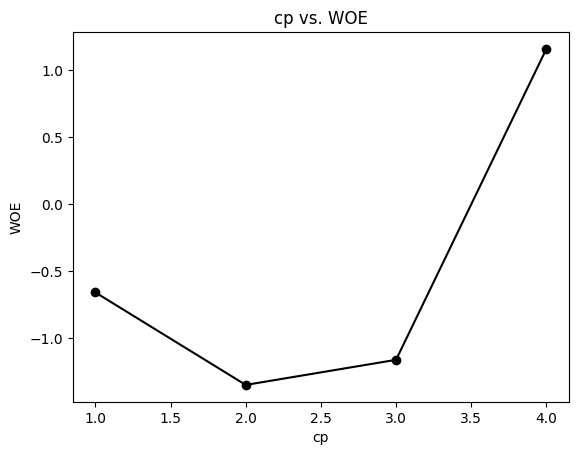

flag_doente,0,1,All,odds,odds_ratio,logito,WOE
cp,,,,,,,
1.0,16,7,23,0.437500,0.516187,-0.826679,-0.661286
2.0,41,9,50,0.219512,0.258993,-1.516347,-1.350955
3.0,68,18,86,0.264706,0.312315,-1.329136,-1.163743
4.0,39,105,144,2.692308,3.176536,0.990399,1.155791
All,164,139,303,0.847561,1.000000,-0.165392,0.000000


In [8]:
#  cp: tipo de dor no peito
#   - 1: angina típica
#   - 2: angina atípica
#   - 3: dor não-angina
#   - 4: assintomático
bivariada(df=df, var_explicativa='cp', var_resposta='flag_doente')

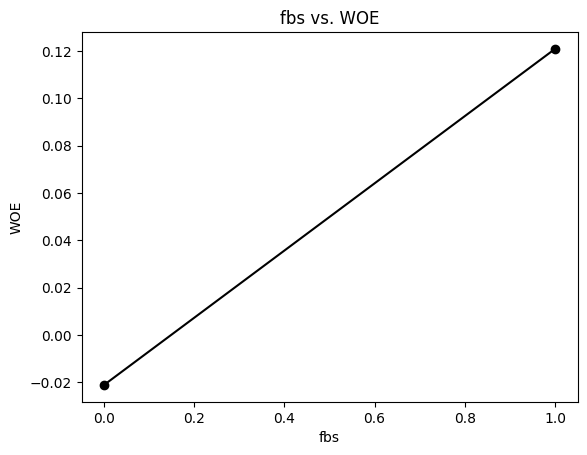

flag_doente,0,1,All,odds,odds_ratio,logito,WOE
fbs,,,,,,,
0.0,141,117,258,0.829787,0.979030,-0.186586,-0.021193
1.0,23,22,45,0.956522,1.128558,-0.044452,0.120941
All,164,139,303,0.847561,1.000000,-0.165392,0.000000


In [9]:
# fbs: (açúcar no sangue em jejum > 120 mg/dl) (1 = True; 0 = False)
bivariada(df=df, var_explicativa='fbs', var_resposta='flag_doente')

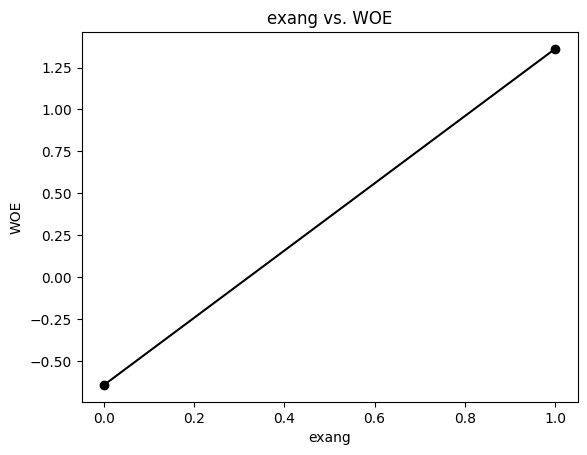

flag_doente,0,1,All,odds,odds_ratio,logito,WOE
exang,,,,,,,
0.0,141,63,204,0.446809,0.527170,-0.805625,-0.640233
1.0,23,76,99,3.304348,3.898655,1.195239,1.360632
All,164,139,303,0.847561,1.000000,-0.165392,0.000000


In [10]:
# exang: angina induzida por exercício(1 = sim; 0 = não)

bivariada(df=df, var_explicativa='exang', var_resposta='flag_doente')

2. Monte uma função semelhante para categorizar variáveis quantitativas contínuas (com muitas categorias) como ```age```.  
    Além dos mesmos parâmetros da função anterior, defina mais um parâmetro como número de categorias que você deseja quebrar. Defina um valor '*default*' de 5 grupos para este parâmetro.  

In [11]:
# função para analise de bivariada contínua
def bivariada_continua(df: pd.DataFrame, var_explicativa: str, var_resposta: str, num_categoria=6) -> pd.DataFrame:

    # separando em grupos
    value_min = df[var_explicativa].min()
    value_max = df[var_explicativa].max()
    intervalo = np.linspace(value_min, value_max, num=num_categoria)
    delta = (value_max - value_min)/num_categoria

    # mostra na tela os intervalos
    print('Intervalos')
    for i,j in enumerate(intervalo):
        print(f'{var_explicativa}_{i+1}: {j} - {j+delta :.1f}')
    
        df[f'grupo_{var_explicativa}'] = pd.cut(df[var_explicativa], bins=intervalo, 
                                                labels=[f'{var_explicativa}_{i+1}' for i in range(num_categoria-1)])

    # filtra as variaveis para analise bivariada
    df_tab = pd.crosstab(df[f'grupo_{var_explicativa}'], df[var_resposta], margins=True)
    # odds
    df_tab['odds'] = df_tab[1] / df_tab[0]
    # odds_ratio (ref: total)
    df_tab['odds_ratio'] = df_tab['odds'] / df_tab.loc['All', 'odds']
    # logito
    df_tab['logito'] = np.log(df_tab['odds'])
    # WOE
    df_tab['WOE'] = np.log(df_tab['odds_ratio'])

    # removendo a ultima linha da tabela para plotar WOE
    df_tab_plot = df_tab.iloc[:-1, :]

    fig, ax = plt.subplots()
    ax.plot(df_tab_plot.index, df_tab_plot['WOE'], color='k')
    ax.scatter(df_tab_plot.index, df_tab_plot['WOE'], color='k')
    ax.set_xlabel(var_explicativa)
    ax.set_ylabel('WOE')
    ax.set_title(f'{var_explicativa} vs. WOE')
    plt.show()

    return df_tab 

Intervalos
age_1: 29.0 - 37.0
age_2: 38.6 - 46.6
age_3: 48.2 - 56.2
age_4: 57.8 - 65.8
age_5: 67.4 - 75.4
age_6: 77.0 - 85.0


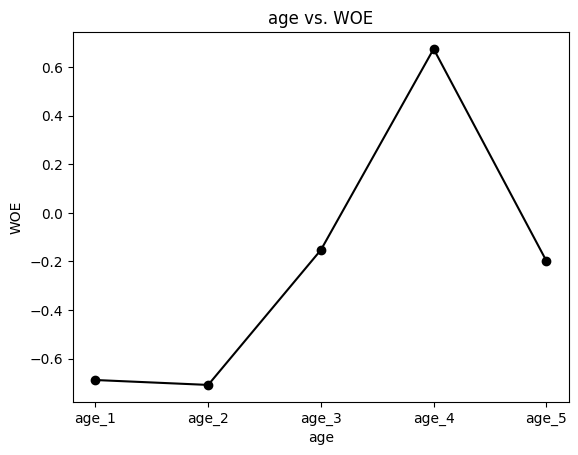

flag_doente,0,1,All,odds,odds_ratio,logito,WOE
grupo_age,,,,,,,
age_1,7,3,10,0.428571,0.502569,-0.847298,-0.688022
age_2,50,21,71,0.420000,0.492518,-0.867501,-0.708224
age_3,56,41,97,0.732143,0.858556,-0.311780,-0.152503
age_4,40,67,107,1.675000,1.964209,0.515813,0.675089
age_5,10,7,17,0.700000,0.820863,-0.356675,-0.197399
All,163,139,302,0.852761,1.000000,-0.159276,0.000000


In [12]:
bivariada_continua(df=df, var_explicativa='age', var_resposta='flag_doente')

3. Construa um modelo de regressão logística com as variáveis qualitativas: ```sex + cp +  trestbps``` e com a variável quantitativa ```age```.

**Interprete os parâmetros.**

In [13]:
reglog = smf.logit('flag_doente ~ sex + C(cp) + trestbps + age',
                   data=df).fit()

reglog.summary()

Optimization terminated successfully.
         Current function value: 0.476154
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      296
Method:                           MLE   Df Model:                            6
Date:                Tue, 25 Apr 2023   Pseudo R-squ.:                  0.3097
Time:                        14:16:15   Log-Likelihood:                -144.27
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 1.692e-25
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -8.3407      1.621     -5.145      0.000     -11.518      -5.163
C(cp)[T.2.0]    -0.0617      0.636     -0.097      0.923      -1.309       1.186
C(cp)[T.3.0]     0.0715      0.573      0.125      0.901      -1.051       1.194
C(cp)[T.4.0]     2.4789      0.553      4.485      0.000       1.396       3.562
sex              1.8094      0.353      5.130      0.000       1.118       2.501
trestbps         0.0193      0.009      2.261      0.024       0.003       0.036
age              0.0567      0.018      3.120      0.002       0.021       0.092
================================================================================
"""

Para o modelo atual,  cp = 2 ou cp = 3 não são significativos.

4. Avalie o seu modelo quanto a **calibragem**:
- Calcule a probabilidade de evento predita segundo o seu modelo
- Categorize essa probabilidade em G=5 grupos
- Calcule a probabilidade de evento predita média por grupo
- Calcule a taxa de eventos (média da variável indicadora de eventos) por grupo
- Compare graficamente o valor eperado versus observado para a taxa de maus por grupo

In [15]:
# calcula o valor predito pelo modelo
df['predito'] = reglog.predict(df)

# separando em 5 grupos
value_min = df['predito'].min()
value_max = df['predito'].max()
intervalo = np.linspace(value_min, value_max, num=6)
value_pred = pd.cut(df['predito'], bins=intervalo)

# agrupa pelo valor predito
group_reg = df.groupby(value_pred)

# quantidade de pacientes por grupo
qualid = group_reg[['flag_doente']].count()
# media de idade
qualid['media_idade'] = group_reg[['age']].mean()
# porcentagem de pacientes doentes
qualid['pct_doentes'] = group_reg['flag_doente'].mean()
# valor medio predito pelo modelo
qualid['predito'] = group_reg['predito'].mean()

qualid

,flag_doente,media_idade,pct_doentes,predito
predito,,,,
"(0.0141, 0.2]",87,49.873563,0.091954,0.101312
"(0.2, 0.386]",55,53.618182,0.272727,0.280916
"(0.386, 0.572]",35,59.514286,0.514286,0.474947
"(0.572, 0.758]",43,53.116279,0.697674,0.656663
"(0.758, 0.944]",82,58.548780,0.829268,0.851972


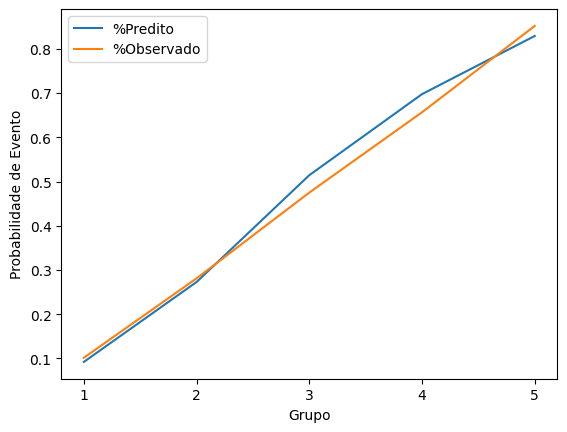

In [16]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax = qualid['pct_doentes'].plot(label='%Predito')
ax = qualid['predito'].plot(label='%Observado')
ticks = ax.set_xticks([0, 1, 2, 3, 4])
labels = ax.set_xticklabels([1, 2, 3, 4, 5])
ax.legend()
ax.set_ylabel('Probabilidade de Evento')
ax.set_xlabel('Grupo')
plt.show()

O modelo está calibrado.

5. Avalie o seu modelo quanto a discriminação calculando acurácia, GINI e KS.

In [25]:
# Define as features e a varíavel resposta
X = df[['sex', 'cp', 'trestbps', 'age']]
y = df['flag_doente']

# Separa a base em teste e treino
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Inicia o modelo logit
reglog = smf.logit('flag_doente ~ sex + C(cp) + trestbps + age', data=df).fit()

# Variaveis para alocar os melhores indices
# acurácia
melhor_acc = 0
# GINI
melhor_gini = 0
# KS
melhor_ks = 0
# AUC (area under the curve)
melhor_auc = 0
# melhor modelo
melhor_model = None

# Utiliza o k-fold para melhor validação com 5 partições
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Interação sobre a base (KFold)
for train_index, test_index in kf.split(X):
    # separa em subconjuntos 
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    
    
    # predições para cada base de testes
    y_pred = reglog.predict(X_test)
    
    # performances de cada subconjunto de testes
    acc = accuracy_score(y_test, y_pred.round())
    gini = 2 * roc_auc_score(y_test, y_pred) - 1
    ks = ks_2samp(y_pred[y_test==1], y_pred[y_test==0]).statistic
    auc = roc_auc_score(y_test, y_pred)
    
    # salva o melhor modelo
    if acc > melhor_acc:
        melhor_acc = acc
        melhor_model = reglog
    if gini > melhor_gini:
        melhor_gini = gini
    if ks > melhor_ks:
        melhor_ks = ks
    if auc > melhor_auc:
        melhor_auc = auc
    
# Imprime as informações junto com o melhor modelo
print("melhor modelo:\n", melhor_model.summary())
print(f"melhor acurácia: {melhor_acc :.2f}")
print(f"melhor gini: {melhor_gini :.2f}")
print(f"melhor KS: {melhor_ks : .2f}")
print(f"melhor AUC: {melhor_auc :.2f}")


Optimization terminated successfully.
         Current function value: 0.476154
         Iterations 6
melhor modelo:
                            Logit Regression Results                           
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      296
Method:                           MLE   Df Model:                            6
Date:                Tue, 25 Apr 2023   Pseudo R-squ.:                  0.3097
Time:                        14:48:48   Log-Likelihood:                -144.27
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 1.692e-25
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -8.3407      1.621     -5.145      0.000     -11.518      -5.163
C(cp)[T

6. tente melhorar o modelo obtido, por exemplo inserindo ou removendo variáveis.  
    Avalie as características do seu modelo (calibragem e acurácia).

In [29]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente,grupo_age,predito
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0,age_4,0.458229
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1,age_4,0.944123
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1,age_4,0.886566
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0,age_1,0.134929
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0,age_2,0.027278


In [33]:
# Inicia o modelo logit
reglog = smf.logit('flag_doente ~ sex + cp + trestbps + age + chol + thalach + exang',
                   data=df).fit()

# Define as features e a varíavel resposta
X = df[['sex', 'cp', 'trestbps', 'age', 'chol', 'thalach', 'exang']]
y = df['flag_doente']

# Separa a base em teste e treino
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Variaveis para alocar os melhores indices
# acurácia
melhor_acc = 0
# GINI
melhor_gini = 0
# KS
melhor_ks = 0
# AUC (area under the curve)
melhor_auc = 0
# melhor modelo
melhor_model = None

# Utiliza o k-fold para melhor validação com 5 partições
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Interação sobre a base (KFold)
for train_index, test_index in kf.split(X):
    # separa em subconjuntos 
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    
    
    # predições para cada base de testes
    y_pred = reglog.predict(X_test)
    
    # performances de cada subconjunto de testes
    acc = accuracy_score(y_test, y_pred.round())
    gini = 2 * roc_auc_score(y_test, y_pred) - 1
    ks = ks_2samp(y_pred[y_test==1], y_pred[y_test==0]).statistic
    auc = roc_auc_score(y_test, y_pred)
    
    # salva o melhor modelo
    if acc > melhor_acc:
        melhor_acc = acc
        melhor_model = reglog
    if gini > melhor_gini:
        melhor_gini = gini
    if ks > melhor_ks:
        melhor_ks = ks
    if auc > melhor_auc:
        melhor_auc = auc
    
# Imprime as informações junto com o melhor modelo
print("melhor modelo:\n", melhor_model.summary())
print(f"melhor acurácia: {melhor_acc :.2f}")
print(f"melhor gini: {melhor_gini :.2f}")
print(f"melhor KS: {melhor_ks : .2f}")
print(f"melhor AUC: {melhor_auc :.2f}")


Optimization terminated successfully.
         Current function value: 0.448501
         Iterations 7
melhor modelo:
                            Logit Regression Results                           
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      295
Method:                           MLE   Df Model:                            7
Date:                Tue, 25 Apr 2023   Pseudo R-squ.:                  0.3498
Time:                        14:57:19   Log-Likelihood:                -135.90
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 2.560e-28
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.7668      2.247     -2.567      0.010     -10.170      -1.364
sex          

No geral, o modelo não melhora significativamente ao adicionar novas variáveis (ou removendo-as). A descrição utilizada no item 5 é satisfatória e mais simples.